In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

from tqdm import tqdm
import numpy as np
import os
import pickle
from collections import OrderedDict
import PIL

from mnist_vae import MnistVAE

In [2]:
dataset = './../../datasets/MNIST/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
data_dim = (1,32,32)
data_size = np.prod(data_dim)
batch_size = 128

In [3]:
# key word args for loading data
kwargs = {'num_workers': 1, 'pin_memory': True} if device == "cuda" else {}

# transformers
transformers = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),         # grayscale images
    transforms.Pad((data_dim[1] - 28) // 2, fill=0, padding_mode='constant'), # padding
    transforms.ToTensor()                                # as tensors
])

test_set = datasets.ImageFolder(dataset + 'test/', transform=transformers)

# load datasets and make them easily fetchable in DataLoaders
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

In [4]:
to_img_torch = transforms.ToPILImage()

def to_img(x):
    img = to_img_torch(x)
    # upsampling. Otherwhgise pdf viewers will fuck with the interpolation
    w, h = img.size
    return img.resize((w*8, h*8), resample=PIL.Image.NEAREST)
    

# Load models

In [8]:
models =OrderedDict()
models['SSIM'] = torch.load('./results/ssim_lam_e9/model.pckl', map_location=device)
models['Watson-fft'] = torch.load('./results/watson-fft_lam_e-1/model.pckl', map_location=device)
models['Deeploss-vgg'] = torch.load('./results/deeploss_lam_e9/model.pckl', map_location=device)

/home/steffen/study/thesis/VAE-perceptual-loss/venv-vae-pytorch/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/steffen/study/thesis/VAE-perceptual-loss/venv-vae-pytorch/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.upsampling.UpsamplingBilinear2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# Reference

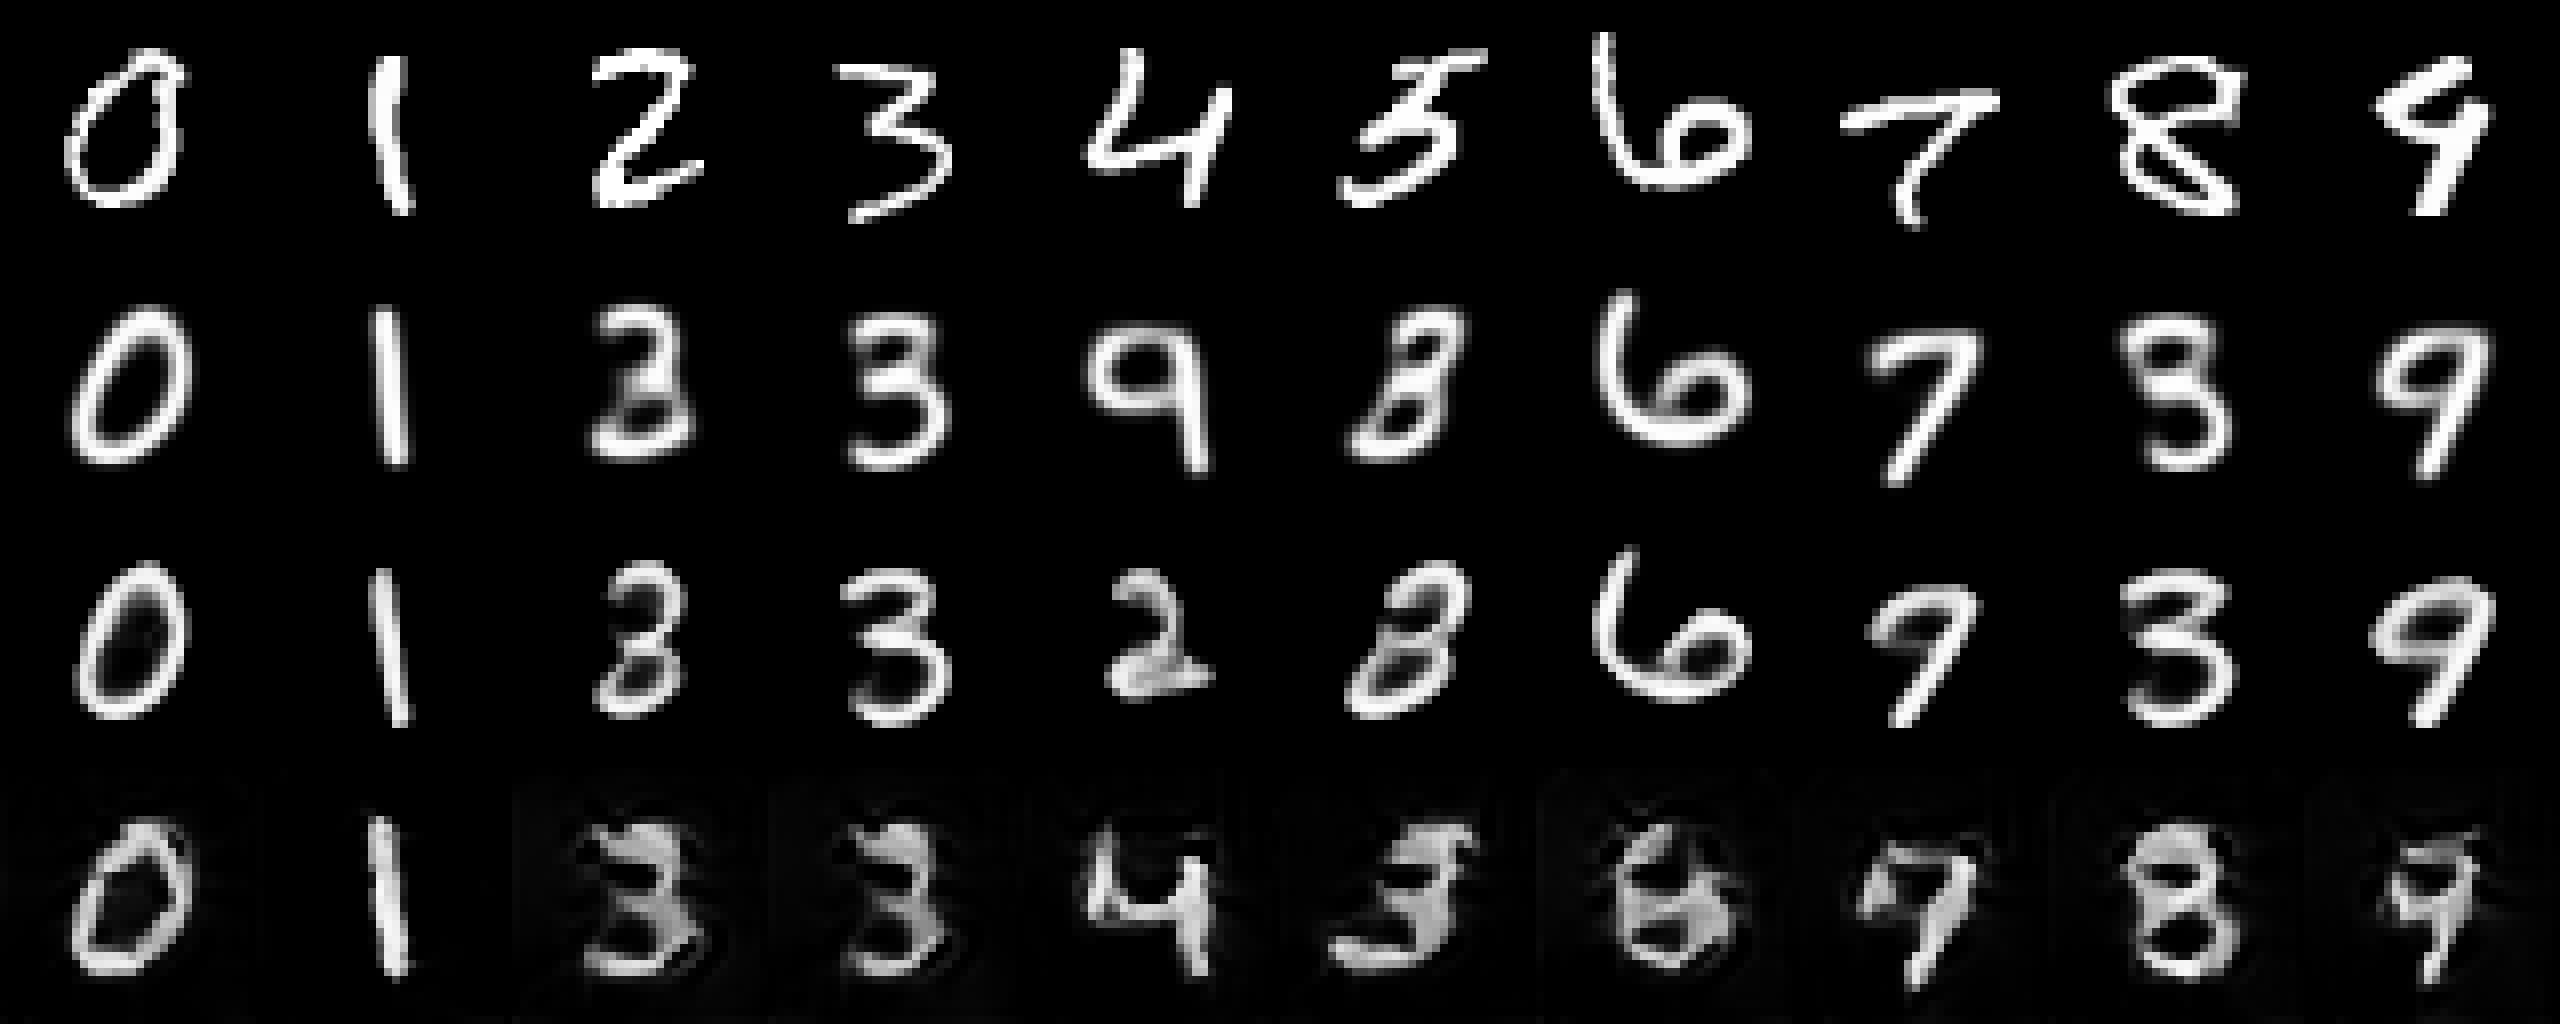

In [12]:
N = 10
#sample reference images
reference = torch.cat([test_set[i*950 + 500][0].expand((1,) + data_dim) for i in range(N)])

recons = reference.clone().cpu()

for k in models:
    z, _ = models[k].encode(reference.to(device))
    recon = models[k].decode(z)
    recons = torch.cat([recons, recon.cpu()])

grid = torchvision.utils.make_grid(recons, nrow=N, padding=0)
img = to_img(grid)

img.save('./comparison/mnist_reconstruction.png')

img

# Interpolation

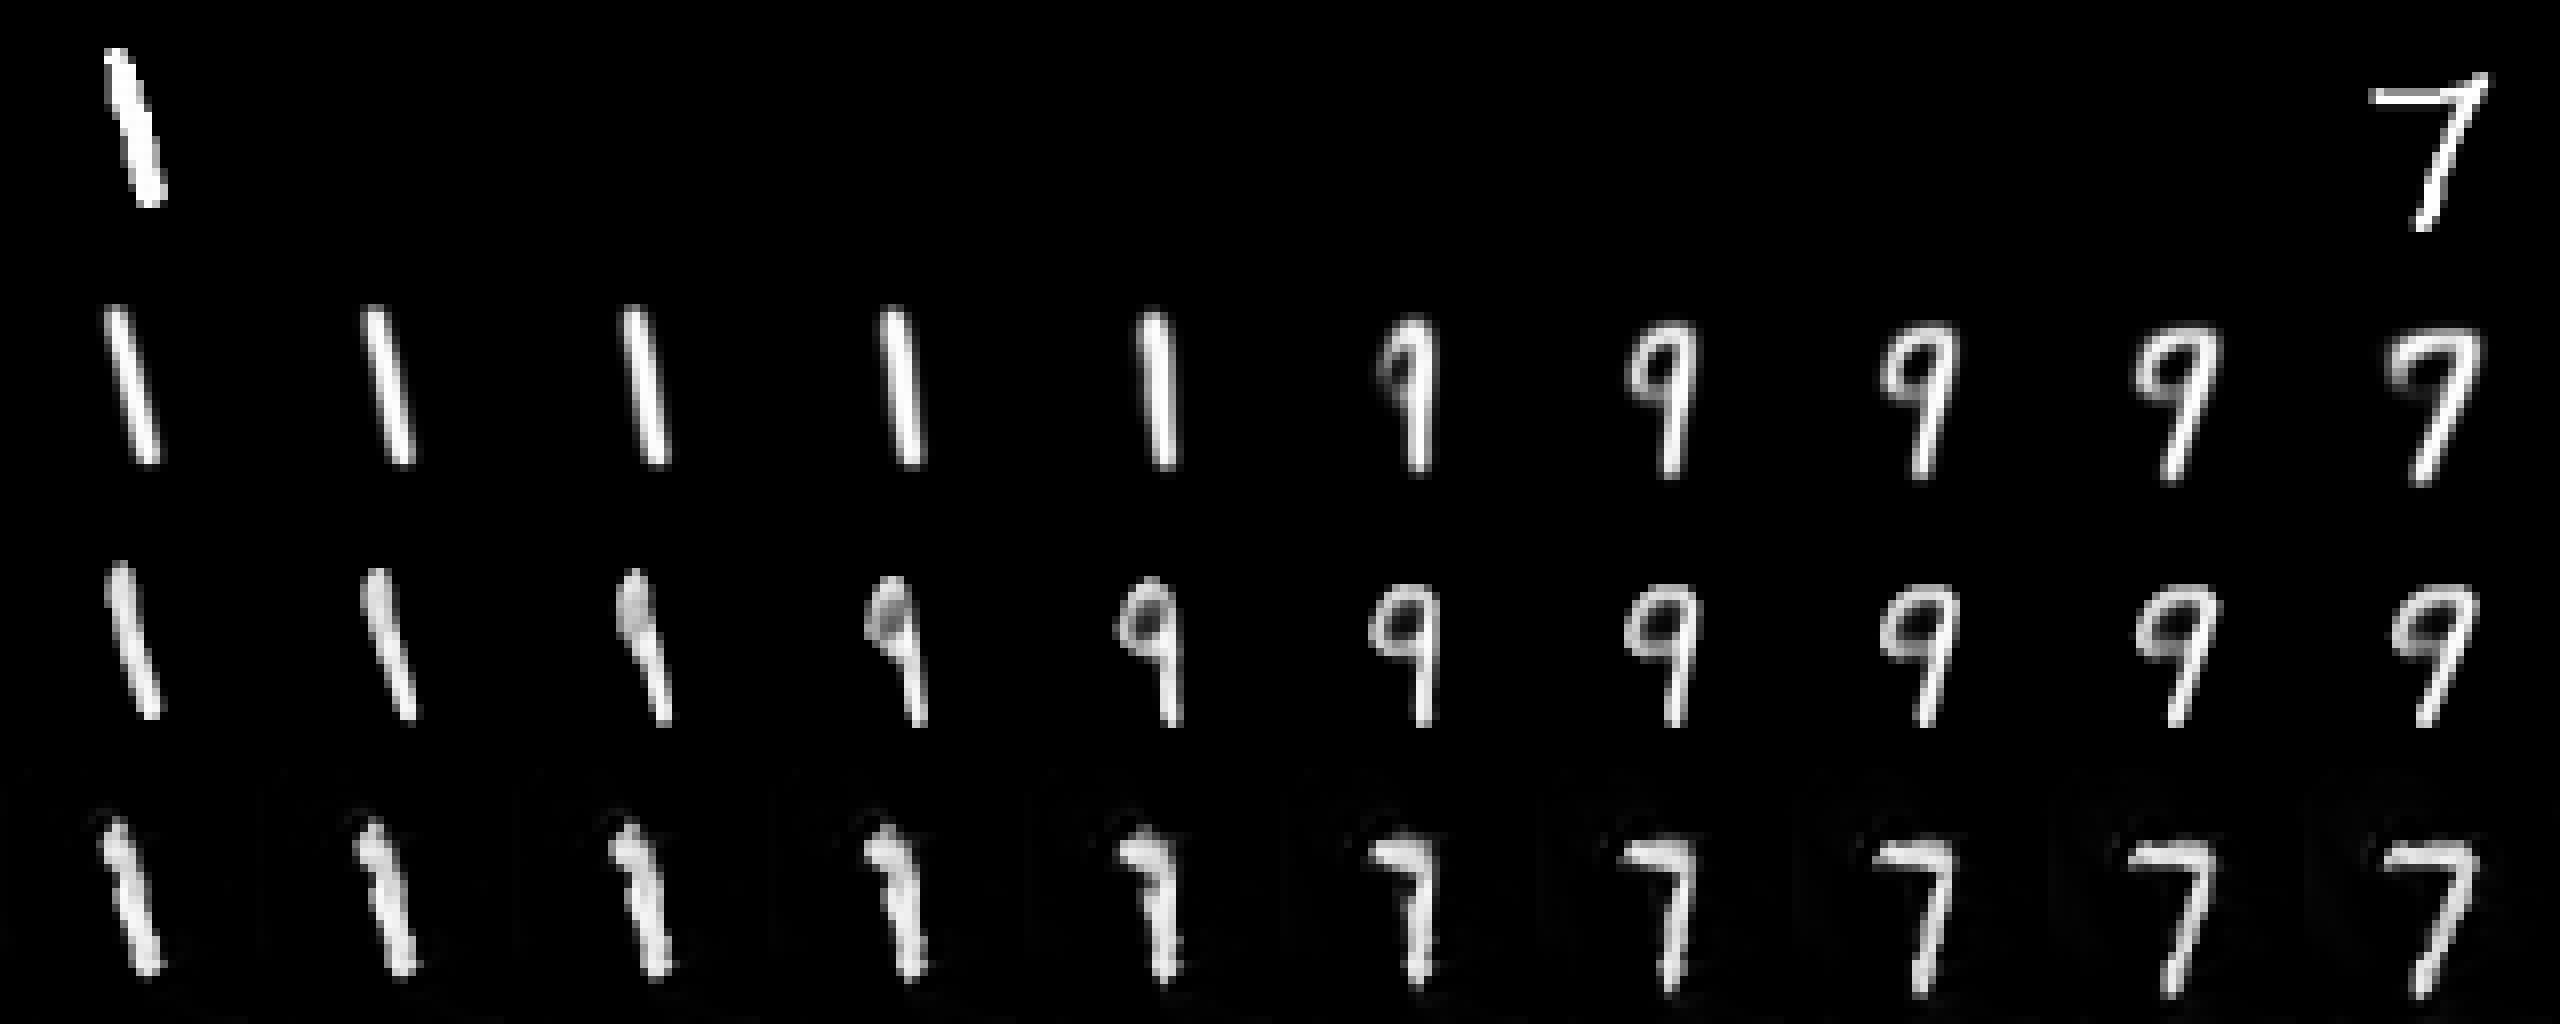

In [13]:
N = 10

s0 = test_set[1117][0].expand((1,) + data_dim)
s1 = test_set[7031][0].expand((1,) + data_dim)

recons = torch.cat([s0, torch.zeros((N-2,) + data_dim) , s1])

for k in models:
    z0, _ = models[k].encode(s0.to(device))
    z1, _ = models[k].encode(s1.to(device))
    zs = torch.cat([n/(N-1) * z1 + (1-n/(N-1)) * z0 for n in range(N)])
    recon = models[k].decode(zs)
    recons = torch.cat([recons, recon.cpu()])

grid = torchvision.utils.make_grid(recons, nrow=N, padding=0)
img = to_img(grid)

img.save('./comparison/mnist_interpolation0.png')

img

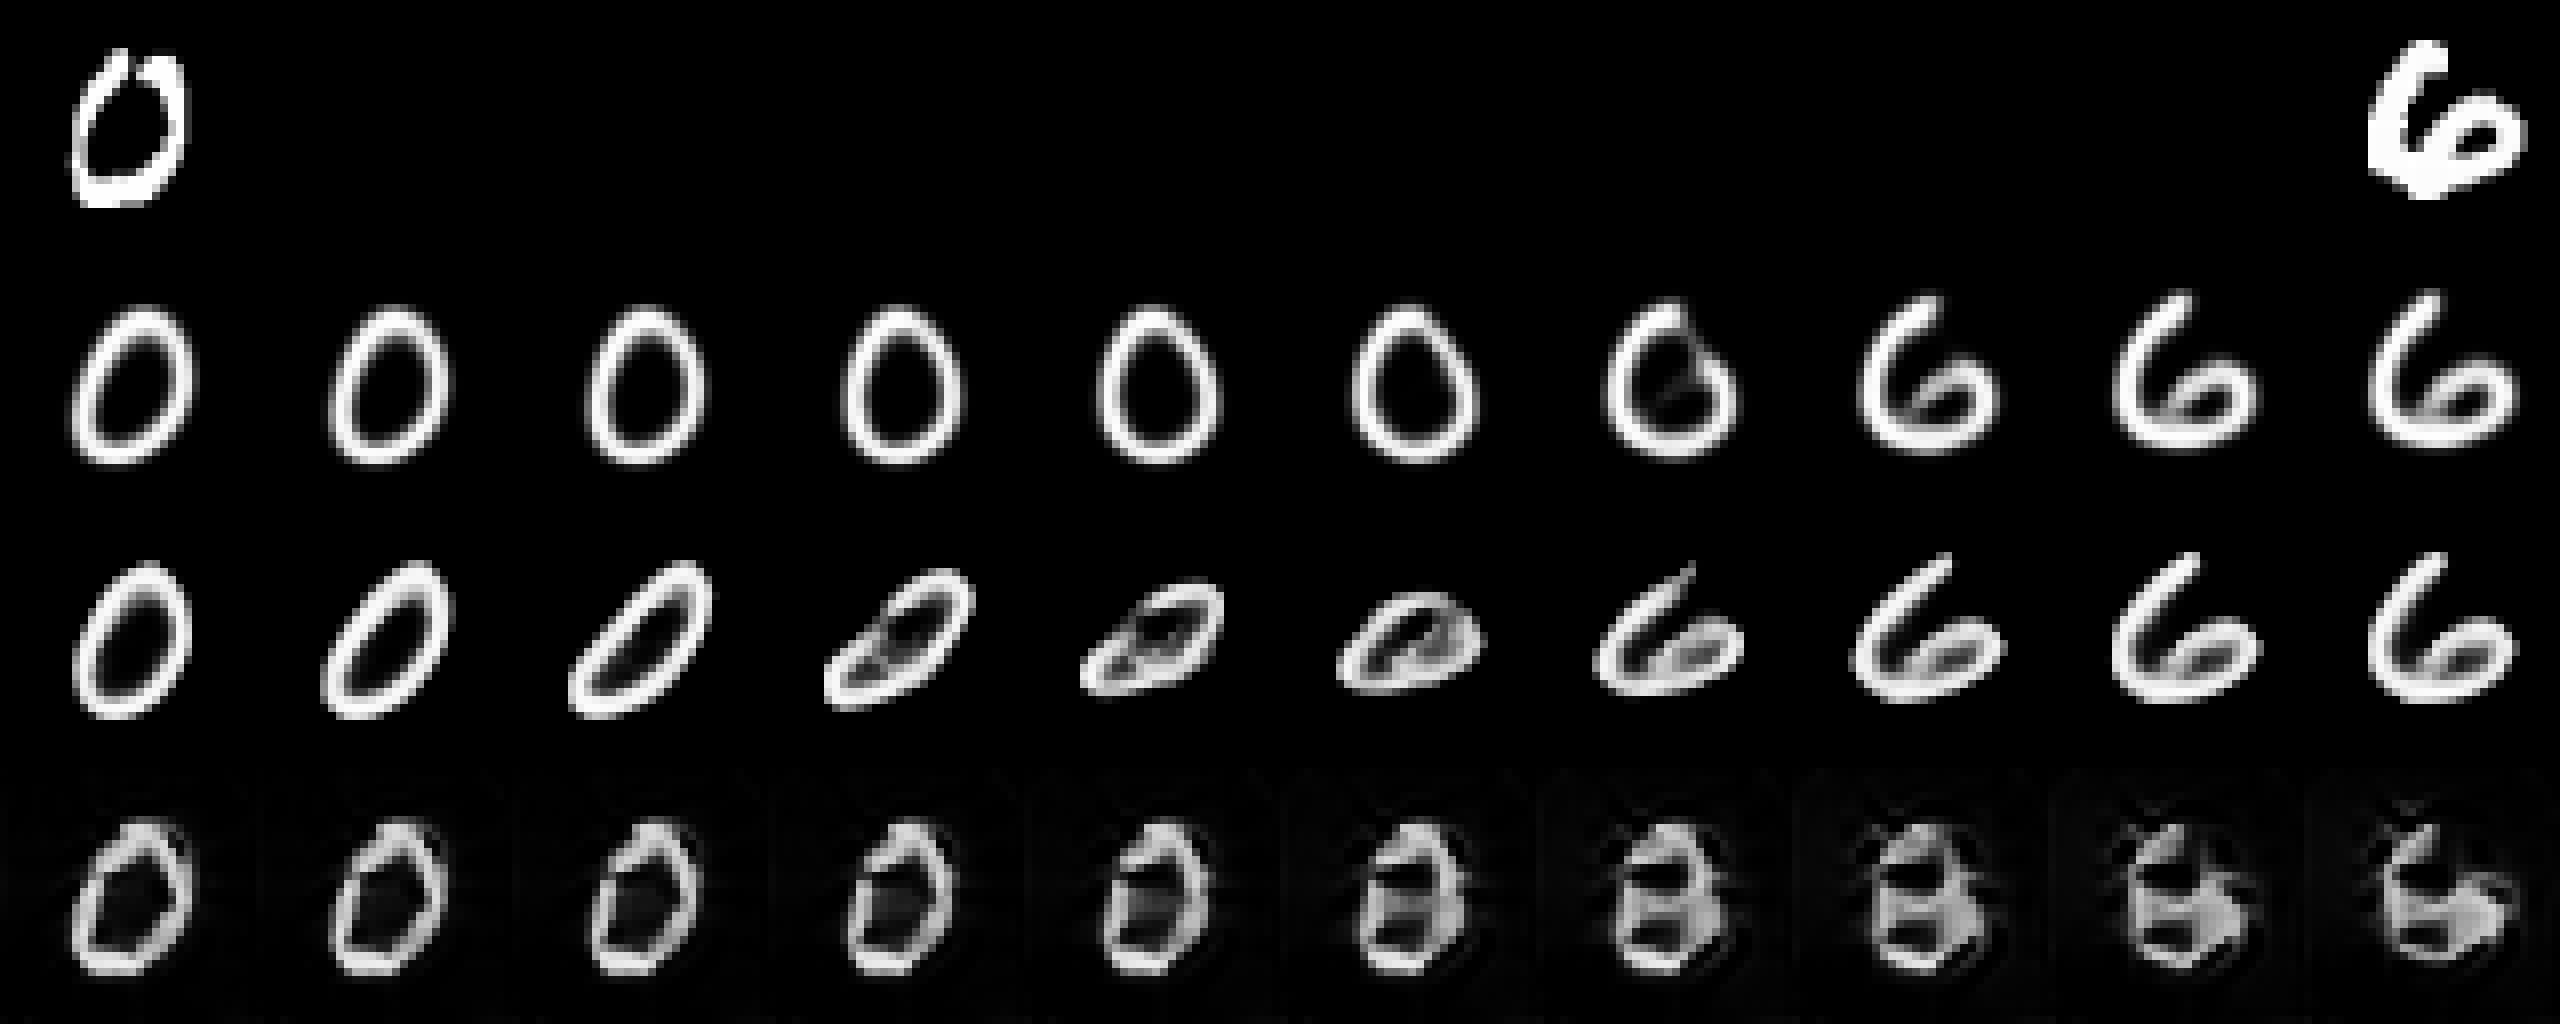

In [14]:
N = 10

s0 = test_set[21][0].expand((1,) + data_dim)
s1 = test_set[6501][0].expand((1,) + data_dim)

recons = torch.cat([s0, torch.zeros((N-2,) + data_dim) , s1])

for k in models:
    z0, _ = models[k].encode(s0.to(device))
    z1, _ = models[k].encode(s1.to(device))
    zs = torch.cat([n/(N-1) * z1 + (1-n/(N-1)) * z0 for n in range(N)])
    recon = models[k].decode(zs)
    recons = torch.cat([recons, recon.cpu()])

grid = torchvision.utils.make_grid(recons, nrow=N, padding=0)
img = to_img(grid)

img.save('./comparison/mnist_interpolation1.png')

img

# Manifolds

In [17]:
manifold_box_size = 1.5


# monte carlo simulation of how much of the latent distribution we capture
in_box = 0
out_box = 0

# def how much gaussian is covered?
for i in tqdm(range(10000)):
    z = np.random.randn(2)
    if (np.abs(z) <= manifold_box_size).all():
        in_box += 1
    else:
        out_box += 1
        
print('{} pct covered by manifold area'.format(in_box / (in_box + out_box) *100))

100%|██████████| 10000/10000 [00:00<00:00, 130872.01it/s]

74.52 pct covered by manifold area


In [18]:
N = 6

z0 = np.array([-manifold_box_size, manifold_box_size])
z0to1 = np.array([2* manifold_box_size, 0.])
z0to2 = np.array([0., -2*manifold_box_size])
zs = []

for y in range(N):
    for x in range(N):
        zs.append(z0 + z0to1 * (x/(N-1)) + z0to2 * (y/(N-1)))
zs = torch.tensor(zs, dtype=torch.float32)
zs = zs.to(device)

for k in models:
    recon = models[k].decode(zs).cpu()
    grid = torchvision.utils.make_grid(recon, nrow=N, padding=0)
    img = to_img(grid)
    img.save('./comparison/mnist_manifold_{}.png'.format(k))

# Dataset sample

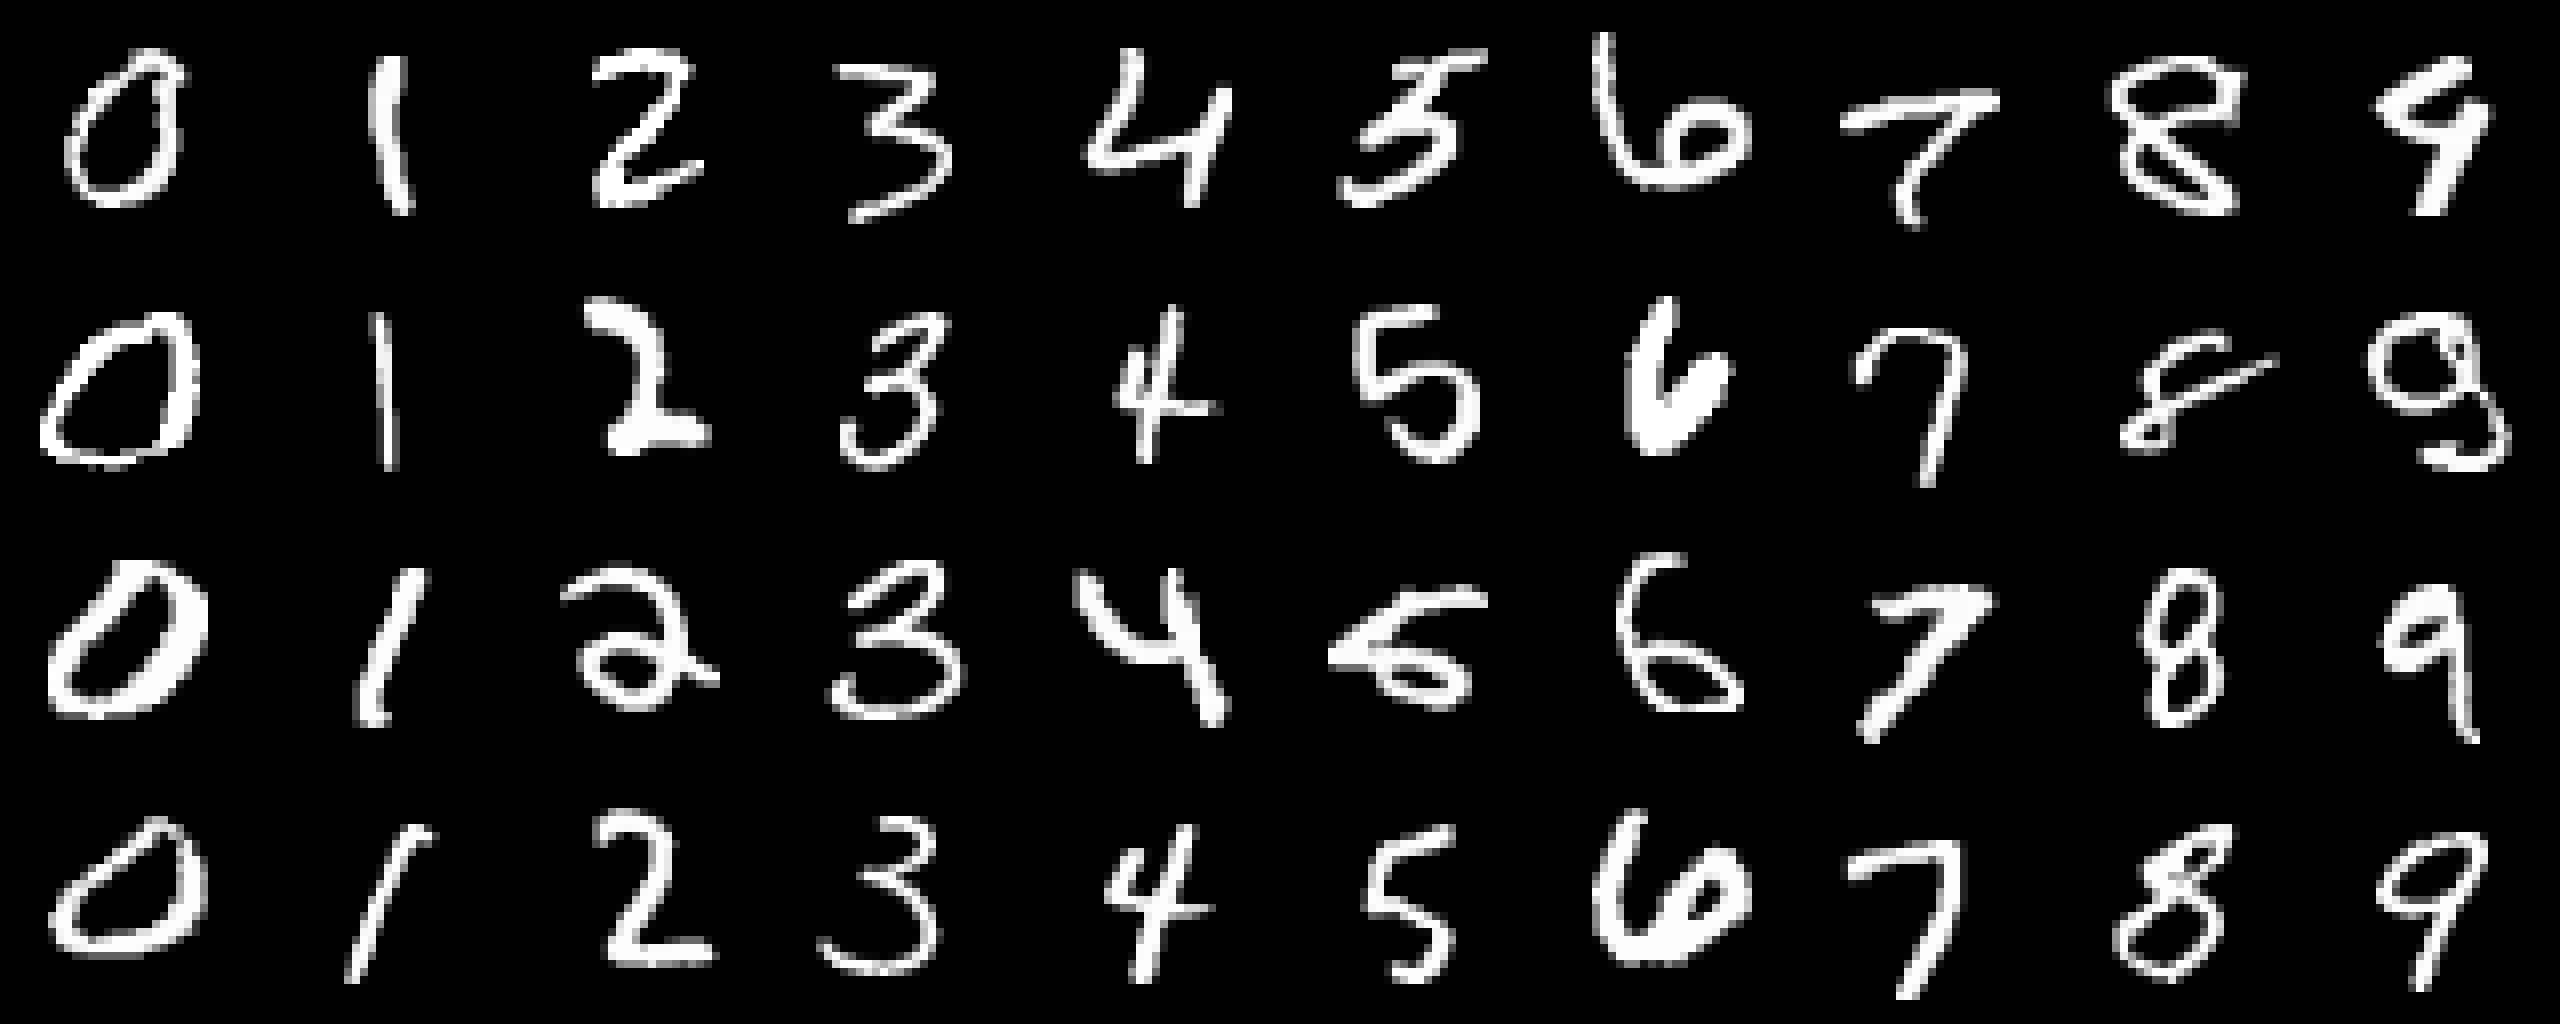

In [10]:
#sample reference images
reference = torch.cat([ \
                       torch.cat([test_set[i*950 + 500+ y][0].expand((1,) + data_dim) for i in range(10)]) \
                       for y in range(4)])

grid = torchvision.utils.make_grid(reference, nrow=10, padding=0, pad_value=1)
img = to_img(grid)
img.save('./comparison/mnist_mexample.png')
img